Imports and Reading Data

In [1]:
# libraries
import os, sys
import pandas as pd
import pickle
import re,string
import spacy,nltk
import sklearn,gensim,tweepy,pyLDAvis
from wordcloud import WordCloud

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/Users/aprilyang/.local/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
# reference source: https://medium.datadriveninvestor.com/trump-tweets-topic-modeling-using-latent-dirichlet-allocation-e4f93b90b6fe
df=pd.read_csv("tweets_01-08-2021.csv")
df.head()

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


In [3]:
tweets_df=df.loc[:,['text']]
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    56571 non-null  object
dtypes: object(1)
memory usage: 442.1+ KB


/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# quick glance at the text
a = 56500
for i in range(a,a+10):
    print(tweets_df.text[i])
    print()

Great support coming from all sides for Border Security (including Wall) on our very dangerous Southern Border. Teams negotiating this weekend! Washington Post and NBC reporting of events, including Fake sources, has been very inaccurate (to put it mildly)!

Thank you to Kanye West for your nice words. Criminal Justice Reform is now law - passed in a very bipartisan way!

Great new book by Dr. Robert Jeffress, “Choosing the Extraordinary Life.” Get it and enjoy!  @LouDobbs

The story in the New York Times regarding Jim Webb being considered as the next Secretary of Defense is FAKE NEWS. I’m sure he is a fine man, but I don’t know Jim, and never met him. Patrick Shanahan, who is Acting Secretary of Defense, is doing a great job!

GREAT JOBS NUMBERS JUST ANNOUNCED!

How do you impeach a president who has won perhaps the greatest election of all time, done nothing wrong (no Collusion with Russia, it was the Dems that Colluded), had the most successful first two years of any president, and

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Data Cleaing -- Using code from Mark

In [5]:
# Data cleaning:
# Lowercase text
# Remove brackets using regular expressions
# remove punctuation and numbers using regular expressions

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'\[.*?\]', '', text)
    
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub("https?://([^\s]+)", ' ', text) # links
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text)
    
    text = re.sub("rt", ' ', text) # RT : 
    text = re.sub(" &amp", ' ', text) # &amp
    text = re.sub("[\n\r\t\0]", ' ', text) # new line, tabs, etc
    text = re.sub('[!,.-;:\"“”\[\]{}]', ' ', text) # punct
    text = re.sub('\s{2,}', ' ', text) # 2+ whitespaces
   
    return text

tweets_df_clean = pd.DataFrame(tweets_df.text.apply(lambda x: clean_text(x)))


/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:12: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \[
<>:19: DeprecationWarning: invalid escape sequence \s
<>:12: DeprecationWarning: invalid escape sequence \s
<>:18: DeprecationWarning: invalid escape sequence \[
<>:19: DeprecationWarning: invalid escape sequence \s
<ipython-input-5-17f1bc126e7b>:12: DeprecationWarning: invalid escape sequence \s
  text = re.sub("https?://([^\s]+)", ' ', text) # links
<ipython-input-5-17f1bc126e7b>:18: DeprecationWarning: invalid escape sequence \[
  text = re.sub('[!,.-;:\"“”\[\]{}]', ' ', text) # punct
<ipython-input-5-17f1bc12

In [6]:
tweets_df_clean.head()

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text
0,republicans and democrats have both created ou...
1,i was thrilled to be back in the great city of...
2,cbs_herridge read letter to surveillance cou ...
3,the unsolicited mail in ballot scam is a major...
4,mzhemingway very friendly telling of events h...


In [7]:
from nltk.corpus import wordnet
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# nltk.download('wordnet') ##################### need this line or will get error -- this line takes forever to run lol, should download the pack manually
import string

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Perform Lemmatization to reduce inflected words to their root words.----cannot run, my computer failed :(
# nlp = spacy.load("en_core_web_sm")
# def lemmatizer(text):        
#     sent = []
#     doc = nlp(text)
#     for word in doc:
#         sent.append(word.lemma_)
#     return " ".join(sent)

from nltk.corpus import wordnet

stop = set(stopwords.words('english'))
def lemmatizer(doc):
    lemma = WordNetLemmatizer()
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
#     punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
    return normalized

tweets_df_clean = pd.DataFrame(tweets_df_clean.text.apply(lambda x: lemmatizer(x)))
tweets_df_clean['text'] = tweets_df_clean['text'].str.replace('-PRON-', '')

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Easy EDAs

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


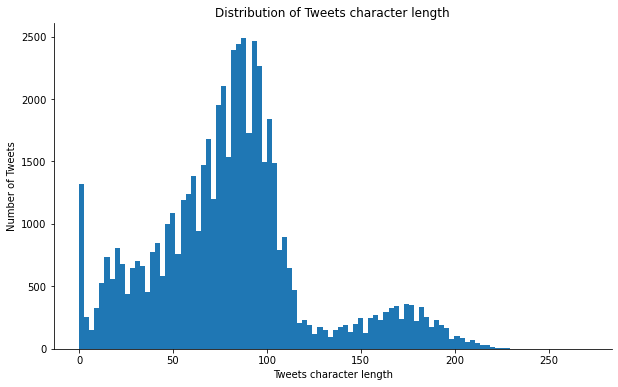

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


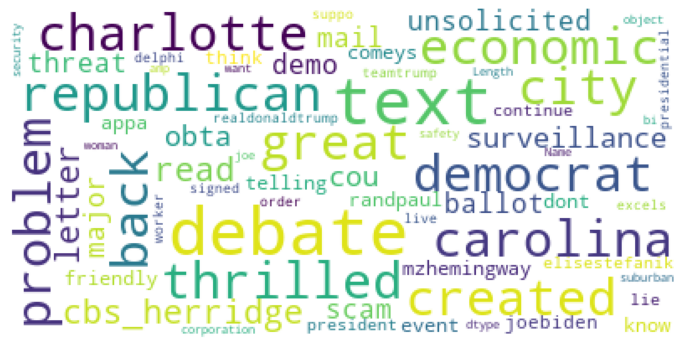

In [10]:
import matplotlib as mpl
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

Unigrams: remove all stop words to get unigrams

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(tweets_df_clean.text, 10)
unigram = pd.DataFrame(common_words, columns = ['unigram' , 'count'])
unigram

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,unigram,count
0,realdonaldtrump,10918
1,trump,7716
2,great,7578
3,amp,5558
4,president,4800
5,thank,3572
6,people,3507
7,country,2750
8,new,2510
9,america,2441


Trigrams

In [12]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3,3),stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in      vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(tweets_df_clean.text, 10)
trigram = pd.DataFrame(common_words, columns = ['trigram' , 'count'])
trigram

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,trigram,count
0,make america great,595
1,fake news medium,259
2,complete total endorsement,225
3,realdonaldtrump run president,171
4,happy bi hday,149
5,crooked hillary clinton,137
6,teamtrump president realdonaldtrump,135
7,new york time,127
8,whitehouse president realdonaldtrump,121
9,radical left democrat,114


Topic modeling with LDA


In [13]:
from sklearn.decomposition import LatentDirichletAllocation
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3,# minimum required occurences of a word 
stop_words='english',# remove stop words
lowercase=True,# convert all words to lowercase
token_pattern='[a-zA-Z0-9]{3,}',# num chars > 3
max_features=5000,# max number of unique words
                            )

data_matrix = vectorizer.fit_transform(tweets_df_clean.text)
data_matrix

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<56571x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 475847 stored elements in Compressed Sparse Row format>

In [14]:
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_matrix)

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# !pip install pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/aprilyang/.local/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:58: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/Users/aprilyang/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:349: DeprecationWarning: `np.float` is a deprecated alias for the buil

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  13.484479
0       0.648955  71.707100       2        1  11.788998
3      71.019684   9.971006       3        1  10.553150
9       3.785981  33.185135       4        1  10.507831
4     -42.666500  -9.222070       5        1   9.696719
6      -3.621689 -43.526516       6        1   9.386009
2      -3.632402  -4.171708       7        1   9.071847
7     -36.584400  35.804413       8        1   9.054775
1      44.391380  50.615383       9        1   8.307872
8      40.235809 -31.591665      10        1   8.148320, topic_info=                 Term          Freq         Total Category  logprob  loglift
3413        president   4715.000000   4715.000000  Default  30.0000  30.0000
3589  realdonaldtrump  10130.000000  10130.000000  Default  29.0000  29.0000
4602            trump   7554.000000   7554.000000  Default  28.0000  28.0000
166               amp   5539.000000   5539.000000  Default  27.0000  27.0000
1921            great   7678.000000   7678.000000  Default  26.0000  26.0000
...               ...           ...           ...      ...      ...      ...
3589  realdonaldtrump   1225.747620  10130.621333  Topic10  -3.4907   0.3953
709            change    284.748752    438.255252  Topic10  -4.9504   2.0762
4838             want    435.767432   1922.965725  Topic10  -4.5249   1.0228
4473            thing    256.436415   1082.663930  Topic10  -5.0551   1.0671
1332             dont    260.783533   1714.363395  Topic10  -5.0383   0.6243

[437 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
16        9  0.996037      absolutely
49        6  0.998650          action
55        6  0.996117        actually
56        8  0.997319            adam
66        3  0.709465  administration
...     ...       ...             ...
4983      9  0.153725            year
4984      3  0.997539             yes
4985      8  0.997888       yesterday
4986      3  0.997838            york
4991      6  0.998704           youre

[482 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 4, 10, 5, 7, 3, 8, 2, 9])

In [22]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 10 words for topic #0:
['big', 'win', 'biden', 'president', 'money', 'run', 'deal', 'trump', 'know', 'going']


Top 10 words for topic #1:
['cnn', 'like', 'amp', 'true', 'state', 'big', 'media', 'fake', 'news', 'just']


Top 10 words for topic #2:
['amazing', 'security', 'crime', 'strong', 'republicans', 'national', 'total', 'amp', 'job', 'thanks']


Top 10 words for topic #3:
['united', 'jobs', 'china', 'hillary', 'states', 'people', 'time', 'country', 'best', 'obama']


Top 10 words for topic #4:
['story', 'illegal', 'law', 'does', 'military', 'left', 'white', 'amp', 'house', 'good']


Top 10 words for topic #5:
['work', 'border', 'thank', 'just', 'vote', 'donald', 'great', 'president', 'trump', 'realdonaldtrump']


Top 10 words for topic #6:
['enjoy', 'thing', 'forward', 'real', 'say', 'foxandfriends', 'amp', 'hard', 'watch', 'tonight']


Top 10 words for topic #7:
['tomorrow', 'nice', 'north', 'help', 'american', 'love', 'make', 'america', 'thank', 'great']


Top 10 words for t

In [16]:
topic_values = lda_model.transform(data_matrix)
tweets_df['Topic'] = topic_values.argmax(axis=1)
tweets_df.head()

/Users/aprilyang/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,Topic
0,Republicans and Democrats have both created ou...,7
1,I was thrilled to be back in the Great city of...,4
2,RT @CBS_Herridge: READ: Letter to surveillance...,6
3,The Unsolicited Mail In Ballot Scam is a major...,4
4,RT @MZHemingway: Very friendly telling of even...,1


In [ ]:
# outputting the topic label and writing into a new csv file
